<a href="https://colab.research.google.com/github/hilaler/natural-language-processing-on-kindle-text-review/blob/main/Experiment_1_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hilal Ramadhan Utomo (1301194236) dan Hajarot Najiha (1301194259)**

In [ ]:
import pandas as pd
import numpy as np
from time import time
import nltk
import re
import multiprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.util import ngrams
from collections import defaultdict, Counter
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP/all_kindle_review.csv", encoding="utf-8")
df.head()

,Unnamed: 0,Unnamed: 0.1,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


# Problem Statement

Terdapat sebuah data yang berisikan tentang review dan perasaan pembaca terhadap sebuah buku kindle. Mereka juga memberikan rating terhadap buku tersebut. Kemudian akan dilakukan klasifikasi terhadap data tersebut berdasarkan rating yang mereka berikan, dan dilakukannya prediksi dengan review baru
Metadata

asin = ID dari produk

helpful = menunjukkan seberapa membantu rating yang diberikan contoh: 8/10.

rating = Rating dari produk.

reviewText = review dari user.

reviewTime = waktu yang digunakan saat mereview.

reviewerID = ID dari reviewer

reviewerName = nama dari reviewer.

summary = catatan singkat dari reviewer.

unixReviewTime = timestamp.

In [ ]:
def ubah_rating(rating):
  if rating >=4:
    return 1
  elif rating <= 3:
    return 0

In [ ]:
df['rating_prep'] = df.rating.apply(lambda x: ubah_rating(int(x)))
df.head()

,Unnamed: 0,Unnamed: 0.1,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,rating_prep
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600,0
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400,1
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400,0
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400,0
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000,1


Text(0.5, 1.0, 'Dataset rating distribution')

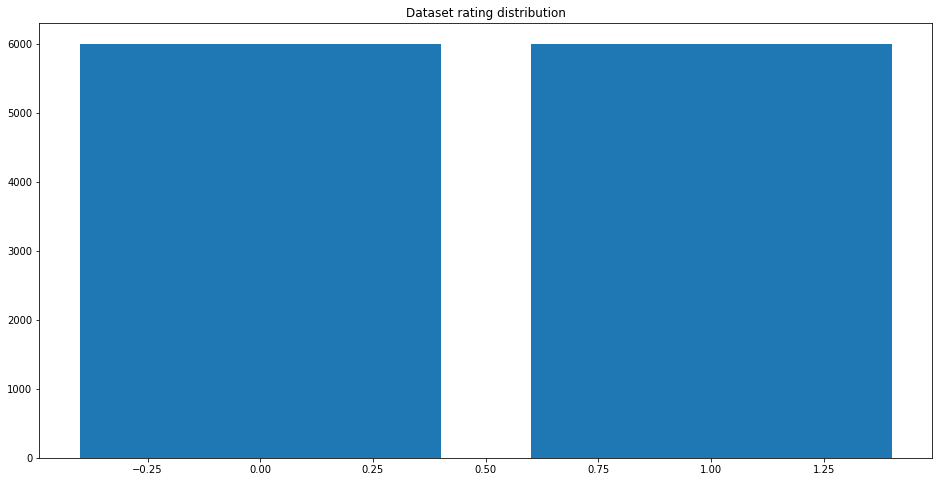

In [ ]:
target_cnt = Counter(df.rating_prep)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset rating distribution")

In [ ]:
df_rev = df[['reviewText','rating_prep']]
df_rev.head()

,reviewText,rating_prep
0,"Jace Rankin may be short, but he's nothing to ...",0
1,Great short read. I didn't want to put it dow...,1
2,I'll start by saying this is the first of four...,0
3,Aggie is Angela Lansbury who carries pocketboo...,0
4,I did not expect this type of book to be in li...,1


In [ ]:
df_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewText   12000 non-null  object
 1   rating_prep  12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 187.6+ KB


In [ ]:
# cek duplicated data
duplicates = df_rev[df_rev.duplicated()]
duplicates

,reviewText,rating_prep


In [ ]:
df_rev.isnull().sum()

reviewText     0
rating_prep    0
dtype: int64

# PREPROCESSING

### LOWER CASTING

In [ ]:
# menyeragamkan semua text menjadi lowercase
list_lower = ['reviewText']

for i in list_lower:
  df_rev[i] = df_rev[i].apply(lambda x: x.lower())

df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,rating_prep
0,"jace rankin may be short, but he's nothing to ...",0
1,great short read. i didn't want to put it dow...,1
2,i'll start by saying this is the first of four...,0
3,aggie is angela lansbury who carries pocketboo...,0
4,i did not expect this type of book to be in li...,1


In [ ]:
# menyeragamkan semua text menjadi lowercase
list_lower =['reviewText']

for i in list_lower:
  df_rev[i] = df_rev[i].apply(lambda x: x.lower())

df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,reviewText,rating_prep
0,"jace rankin may be short, but he's nothing to ...",0
1,great short read. i didn't want to put it dow...,1
2,i'll start by saying this is the first of four...,0
3,aggie is angela lansbury who carries pocketboo...,0
4,i did not expect this type of book to be in li...,1


### Removing unwanted char

In [ ]:
# menghilangkan format html
html_tag = re.compile(r'<.*?>')
# menghilangkan format URL
http_link = re.compile(r'https://\S+')
www_link = re.compile(r'www\.\S+')
# menghilangkan tanda baca
punct = re.compile(r"[^\w\s]")
# menghilangkan angka
number = re.compile(r"\d")
# menghilangkan double spasi
space = re.compile(r"\s\s+")

def clean_data(text):
    text = re.sub(html_tag, r" ", text)
    text = re.sub(http_link, r" ", text)
    text = re.sub(www_link, r" ", text)
    text = re.sub(punct, r" ", text)
    text = re.sub(number, r" ", text)
    text = re.sub(space, r"", text)
    return text

In [ ]:
df_rev['no_unwanted'] = df_rev['reviewText'].apply(lambda x: clean_data(x))
df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewText,rating_prep,no_unwanted
0,"jace rankin may be short, but he's nothing to ...",0,jace rankin may be shortbut he s nothing to me...
1,great short read. i didn't want to put it dow...,1,great short readi didn t want to put it down s...
2,i'll start by saying this is the first of four...,0,i ll start by saying this is the first of four...
3,aggie is angela lansbury who carries pocketboo...,0,aggie is angela lansbury who carries pocketboo...
4,i did not expect this type of book to be in li...,1,i did not expect this type of book to be in li...


### Tokenization

In [ ]:
df_rev['token'] = df_rev['no_unwanted'].apply(lambda x: word_tokenize(x))
df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewText,rating_prep,no_unwanted,token
0,"jace rankin may be short, but he's nothing to ...",0,jace rankin may be shortbut he s nothing to me...,"[jace, rankin, may, be, shortbut, he, s, nothi..."
1,great short read. i didn't want to put it dow...,1,great short readi didn t want to put it down s...,"[great, short, readi, didn, t, want, to, put, ..."
2,i'll start by saying this is the first of four...,0,i ll start by saying this is the first of four...,"[i, ll, start, by, saying, this, is, the, firs..."
3,aggie is angela lansbury who carries pocketboo...,0,aggie is angela lansbury who carries pocketboo...,"[aggie, is, angela, lansbury, who, carries, po..."
4,i did not expect this type of book to be in li...,1,i did not expect this type of book to be in li...,"[i, did, not, expect, this, type, of, book, to..."


### Stemming n Lemmanization

In [ ]:
# stemming menggunakan NLTK
ps = PorterStemmer()
df_rev['stem'] = df_rev['token'].apply(lambda x: [ps.stem(word) for word in x])
df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reviewText,rating_prep,no_unwanted,token,stem
0,"jace rankin may be short, but he's nothing to ...",0,jace rankin may be shortbut he s nothing to me...,"[jace, rankin, may, be, shortbut, he, s, nothi...","[jace, rankin, may, be, shortbut, he, s, noth,..."
1,great short read. i didn't want to put it dow...,1,great short readi didn t want to put it down s...,"[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ..."
2,i'll start by saying this is the first of four...,0,i ll start by saying this is the first of four...,"[i, ll, start, by, saying, this, is, the, firs...","[i, ll, start, by, say, thi, is, the, first, o..."
3,aggie is angela lansbury who carries pocketboo...,0,aggie is angela lansbury who carries pocketboo...,"[aggie, is, angela, lansbury, who, carries, po...","[aggi, is, angela, lansburi, who, carri, pocke..."
4,i did not expect this type of book to be in li...,1,i did not expect this type of book to be in li...,"[i, did, not, expect, this, type, of, book, to...","[i, did, not, expect, thi, type, of, book, to,..."


In [ ]:
# lemmatization menggunakan NLTK
lemmatizer = WordNetLemmatizer()
df_rev['lemmatize'] = df_rev['stem'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,reviewText,rating_prep,no_unwanted,token,stem,lemmatize
0,"jace rankin may be short, but he's nothing to ...",0,jace rankin may be shortbut he s nothing to me...,"[jace, rankin, may, be, shortbut, he, s, nothi...","[jace, rankin, may, be, shortbut, he, s, noth,...","[jace, rankin, may, be, shortbut, he, s, noth,..."
1,great short read. i didn't want to put it dow...,1,great short readi didn t want to put it down s...,"[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ..."
2,i'll start by saying this is the first of four...,0,i ll start by saying this is the first of four...,"[i, ll, start, by, saying, this, is, the, firs...","[i, ll, start, by, say, thi, is, the, first, o...","[i, ll, start, by, say, thi, is, the, first, o..."
3,aggie is angela lansbury who carries pocketboo...,0,aggie is angela lansbury who carries pocketboo...,"[aggie, is, angela, lansbury, who, carries, po...","[aggi, is, angela, lansburi, who, carri, pocke...","[aggi, is, angela, lansburi, who, carri, pocke..."
4,i did not expect this type of book to be in li...,1,i did not expect this type of book to be in li...,"[i, did, not, expect, this, type, of, book, to...","[i, did, not, expect, thi, type, of, book, to,...","[i, did, not, expect, thi, type, of, book, to,..."


### Stopword Removal

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
# menghapus kata-kata negatif yang dianggap sebagai stopwords
stop_words.remove("aren't")
stop_words.remove("couldn't")
stop_words.remove("didn't")
stop_words.remove("doesn't")
stop_words.remove("don't")
stop_words.remove("hadn't")
stop_words.remove("hasn't")
stop_words.remove("haven't")
stop_words.remove("isn't")
stop_words.remove("mightn't")
stop_words.remove("mustn't")
stop_words.remove("needn't")
stop_words.remove("shouldn't")
stop_words.remove("wasn't")
stop_words.remove("weren't")
stop_words.remove("won't")
stop_words.remove("wouldn't")
stop_words.remove("shan't")
stop_words.remove("against")
stop_words.remove("ain")
stop_words.remove("aren")
stop_words.remove("couldn")
stop_words.remove("didn")
stop_words.remove("doesn")
stop_words.remove("hadn")
stop_words.remove("hasn")
stop_words.remove("haven")
stop_words.remove("mightn")
stop_words.remove("needn")
stop_words.remove("shouldn")
stop_words.remove("wasn")
stop_words.remove("weren")
stop_words.remove("wouldn")
stop_words.remove("mustn")
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'd',
 'did',
 'do',
 'does',
 'doing',
 'don',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'has',
 'have',
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'more',
 'most',
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'shan',
 'she',
 "she's",
 'should',
 "should've",
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 '

In [ ]:
df_rev['clean'] = df_rev['lemmatize'].apply(lambda x: [word for word in x if word not in stop_words])
df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewText,rating_prep,no_unwanted,token,stem,lemmatize,clean
0,"jace rankin may be short, but he's nothing to ...",0,jace rankin may be shortbut he s nothing to me...,"[jace, rankin, may, be, shortbut, he, s, nothi...","[jace, rankin, may, be, shortbut, he, s, noth,...","[jace, rankin, may, be, shortbut, he, s, noth,...","[jace, rankin, may, shortbut, noth, mess, with..."
1,great short read. i didn't want to put it dow...,1,great short readi didn t want to put it down s...,"[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, want, put, read, o..."
2,i'll start by saying this is the first of four...,0,i ll start by saying this is the first of four...,"[i, ll, start, by, saying, this, is, the, firs...","[i, ll, start, by, say, thi, is, the, first, o...","[i, ll, start, by, say, thi, is, the, first, o...","[start, say, thi, first, four, book, wasn, exp..."
3,aggie is angela lansbury who carries pocketboo...,0,aggie is angela lansbury who carries pocketboo...,"[aggie, is, angela, lansbury, who, carries, po...","[aggi, is, angela, lansburi, who, carri, pocke...","[aggi, is, angela, lansburi, who, carri, pocke...","[aggi, angela, lansburi, carri, pocketbook, in..."
4,i did not expect this type of book to be in li...,1,i did not expect this type of book to be in li...,"[i, did, not, expect, this, type, of, book, to...","[i, did, not, expect, thi, type, of, book, to,...","[i, did, not, expect, thi, type, of, book, to,...","[expect, thi, type, book, librari, wa, plea, f..."


In [ ]:
# Menggabungkan kata-kata menjadi satu kalimat utuh
df_rev["review"] = df_rev["clean"].apply(lambda x: " ".join(x))
df_rev.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,rating_prep,no_unwanted,token,stem,lemmatize,clean,review
0,"jace rankin may be short, but he's nothing to ...",0,jace rankin may be shortbut he s nothing to me...,"[jace, rankin, may, be, shortbut, he, s, nothi...","[jace, rankin, may, be, shortbut, he, s, noth,...","[jace, rankin, may, be, shortbut, he, s, noth,...","[jace, rankin, may, shortbut, noth, mess, with...",jace rankin may shortbut noth mess witha man w...
1,great short read. i didn't want to put it dow...,1,great short readi didn t want to put it down s...,"[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, want, put, read, o...",great short readi didn want put read one sitti...
2,i'll start by saying this is the first of four...,0,i ll start by saying this is the first of four...,"[i, ll, start, by, saying, this, is, the, firs...","[i, ll, start, by, say, thi, is, the, first, o...","[i, ll, start, by, say, thi, is, the, first, o...","[start, say, thi, first, four, book, wasn, exp...",start say thi first four book wasn expect toco...
3,aggie is angela lansbury who carries pocketboo...,0,aggie is angela lansbury who carries pocketboo...,"[aggie, is, angela, lansbury, who, carries, po...","[aggi, is, angela, lansburi, who, carri, pocke...","[aggi, is, angela, lansburi, who, carri, pocke...","[aggi, angela, lansburi, carri, pocketbook, in...",aggi angela lansburi carri pocketbook instead ...
4,i did not expect this type of book to be in li...,1,i did not expect this type of book to be in li...,"[i, did, not, expect, this, type, of, book, to...","[i, did, not, expect, thi, type, of, book, to,...","[i, did, not, expect, thi, type, of, book, to,...","[expect, thi, type, book, librari, wa, plea, f...",expect thi type book librari wa plea find pric...


# Eksplorasi Data

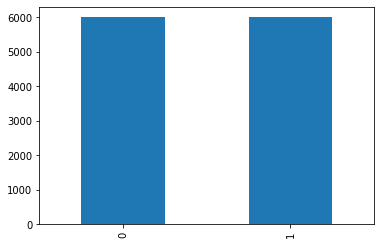

In [ ]:
# plot banyaknya rating dari data
label_rating = df_rev['rating_prep'].value_counts()
label_rating.plot(kind='bar')
plt.show()

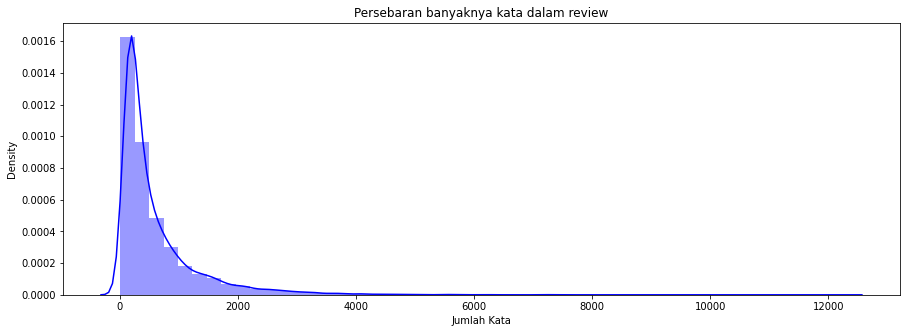

In [ ]:
# melihat persebaran banyaknya kata yang digunakan dalam reviewText sebelum dibersihkan

count_words = df_rev['reviewText'].apply(lambda x: len(x))

plt.subplots(figsize=(15,5))
sns.distplot(count_words, color='Blue')
plt.title('Persebaran banyaknya kata dalam review')
plt.xlabel('Jumlah Kata')
plt.show()

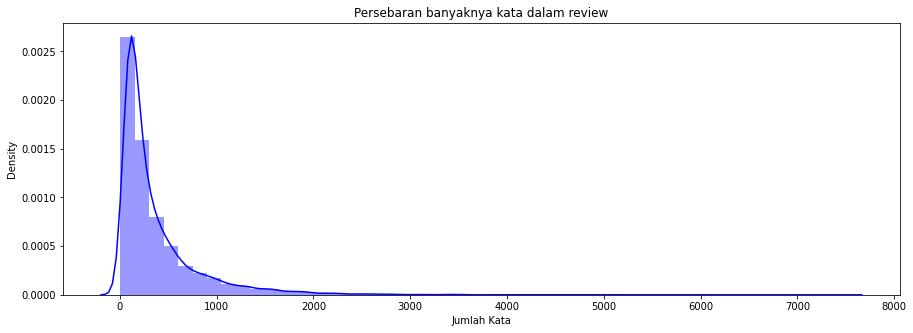

In [ ]:
# melihat persebaran banyaknya kata yang digunakan dalam review setelah dibersihkan

count_words = df_rev['review'].apply(lambda x: len(x))

plt.subplots(figsize=(15,5))
sns.distplot(count_words, color='Blue')
plt.title('Persebaran banyaknya kata dalam review')
plt.xlabel('Jumlah Kata')
plt.show()

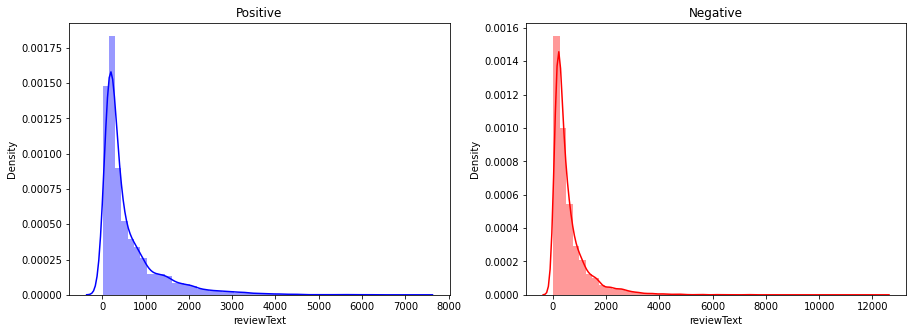

In [ ]:
# melihat banyaknya input kata yang digunakan saat mereview berdasarkan rating sebelum dibersihkan

positif = df_rev[df_rev['rating_prep'] ==1 ]
negatif = df_rev[df_rev['rating_prep'] == 0]

count_positif = positif['reviewText'].apply(lambda x: len(x))
count_negatif = negatif['reviewText'].apply(lambda x: len(x))

fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
sns.distplot(count_positif, ax=ax1, color='Blue')
ax1.set_title('Positive')
sns.distplot(count_negatif, ax=ax2, color='Red')
ax2.set_title('Negative')
plt.show()

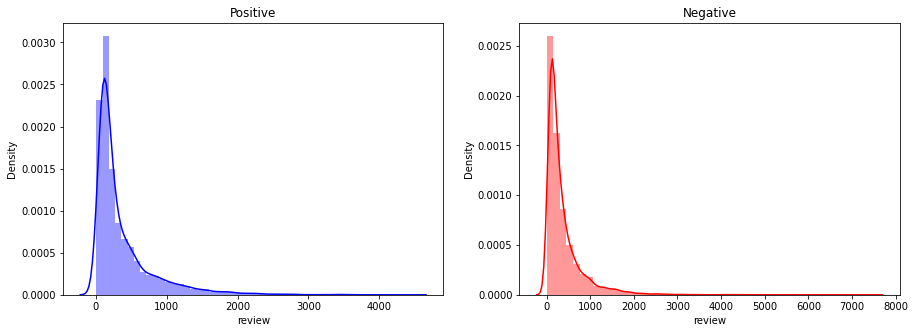

In [ ]:
# melihat banyaknya input kata yang digunakan saat mereview berdasarkan rating setelah dibersihkan

count_positif_ = positif['review'].apply(lambda x: len(x))
count_negatif_ = negatif['review'].apply(lambda x: len(x))

fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
sns.distplot(count_positif_, ax=ax1, color='Blue')
ax1.set_title('Positive')
sns.distplot(count_negatif_, ax=ax2, color='Red')
ax2.set_title('Negative')
plt.show()

# Feature Engineering

### Using N-gram

In [ ]:
# Mencari tf-idf dengan menggunakan unigram dan bigram
start_time = datetime.now()
tfidf_vect_2 = TfidfVectorizer(ngram_range=(1,2))
tfidf_2 = tfidf_vect_2.fit_transform(df_rev["review"])
tfidf_2.shape
end_time = datetime.now()
print('Waktu yang diperlukan: {}'.format(end_time - start_time))

Waktu yang diperlukan: 0:00:03.807619


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
tfidfVal = tfidf.fit_transform(tfidf_2)
print(tfidfVal.shape)

(12000, 534671)


In [ ]:
# membagi train test data (tfidf dengan unigram dan bigram)
X = tfidfVal
y = df_rev['rating_prep']

x_train_ngram, x_test_ngram, y_train_ngram, y_test_ngram = train_test_split(X, y, test_size=0.2)

print("X Train : ", (x_train_ngram.shape))
print("y Train : ", (y_train_ngram.shape))
print("X Test : ", (x_test_ngram.shape))
print("y Test : ", (y_test_ngram.shape))

X Train :  (9600, 534671)
y Train :  (9600,)
X Test :  (2400, 534671)
y Test :  (2400,)


### Neural Based

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 827.9 MB 1.1 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=ac428487ef719452117c6b59af542b8b810799416ffdf150463df23ba83228cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3zyi87l/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

In [ ]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [ ]:
start_time = datetime.now()
df_rev['vec'] = df_rev['review'].apply(lambda x: get_vec(x))
end_time = datetime.now()
print('Waktu yang diperlukan: {}'.format(end_time - start_time))

Waktu yang diperlukan: 0:06:18.461522


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_rev.head()

,reviewText,rating_prep,no_unwanted,token,stem,lemmatize,clean,review,vec
0,"jace rankin may be short, but he's nothing to ...",0,jace rankin may be shortbut he s nothing to me...,"[jace, rankin, may, be, shortbut, he, s, nothi...","[jace, rankin, may, be, shortbut, he, s, noth,...","[jace, rankin, may, be, shortbut, he, s, noth,...","[jace, rankin, may, shortbut, noth, mess, with...",jace rankin may shortbut noth mess witha man w...,"[-0.031910267, 0.06658661, -0.10255583, -0.052..."
1,great short read. i didn't want to put it dow...,1,great short readi didn t want to put it down s...,"[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, t, want, to, put, ...","[great, short, readi, didn, want, put, read, o...",great short readi didn want put read one sitti...,"[0.009384433, 0.13183084, -0.14968857, -0.0261..."
2,i'll start by saying this is the first of four...,0,i ll start by saying this is the first of four...,"[i, ll, start, by, saying, this, is, the, firs...","[i, ll, start, by, say, thi, is, the, first, o...","[i, ll, start, by, say, thi, is, the, first, o...","[start, say, thi, first, four, book, wasn, exp...",start say thi first four book wasn expect toco...,"[0.00957457, 0.11897439, -0.18392138, -0.04472..."
3,aggie is angela lansbury who carries pocketboo...,0,aggie is angela lansbury who carries pocketboo...,"[aggie, is, angela, lansbury, who, carries, po...","[aggi, is, angela, lansburi, who, carri, pocke...","[aggi, is, angela, lansburi, who, carri, pocke...","[aggi, angela, lansburi, carri, pocketbook, in...",aggi angela lansburi carri pocketbook instead ...,"[-0.025091577, 0.104308456, -0.012502388, -0.0..."
4,i did not expect this type of book to be in li...,1,i did not expect this type of book to be in li...,"[i, did, not, expect, this, type, of, book, to...","[i, did, not, expect, thi, type, of, book, to,...","[i, did, not, expect, thi, type, of, book, to,...","[expect, thi, type, book, librari, wa, plea, f...",expect thi type book librari wa plea find pric...,"[-0.1730852, 0.1493309, -0.13972282, -0.130633..."


In [ ]:
X = df_rev['vec'].to_numpy()
X = X.reshape(-1, 1)

In [ ]:
X.shape

(12000, 1)

In [ ]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [ ]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(X, df_rev['rating_prep'], test_size = 0.2)
print("X Train : ", (x_train_nn.shape))
print("y Train : ", (y_train_nn.shape))
print("X Test : ", (x_test_nn.shape))
print("y Test : ", (y_test_nn.shape))

X Train :  (9600, 300)
y Train :  (9600,)
X Test :  (2400, 300)
y Test :  (2400,)


In [ ]:
x_train_nn.shape, x_test_nn.shape

((9600, 300), (2400, 300))

# Modelling

In [ ]:
# Modelling dengan Random Forest Ngram
start_time = datetime.now()
rfc_ngram = RandomForestClassifier(random_state=0).fit(x_train_ngram,y_train_ngram)
predicted_rfc_ngram=rfc_ngram.predict(x_test_ngram)
print('******** Random Forest Classifier N gram **********')
print('MultinomialRFC Accuracy:', accuracy_score(y_test_ngram, predicted_rfc_ngram))
print('MultinomialRFC Precision:', precision_score(y_test_ngram, predicted_rfc_ngram, average=None))
print('MultinomialRFC Recall:', recall_score(y_test_ngram, predicted_rfc_ngram, average=None))
print('MultinomialRFC f1_score:', f1_score(y_test_ngram, predicted_rfc_ngram, average=None))
end_time = datetime.now()
print('Waktu yang diperlukan: {}'.format(end_time - start_time))

******** Random Forest Classifier N gram **********
MultinomialRFC Accuracy: 0.7845833333333333
MultinomialRFC Precision: [0.79834711 0.77058824]
MultinomialRFC Recall: [0.77966102 0.78983635]
MultinomialRFC f1_score: [0.78889343 0.78009358]
Waktu yang diperlukan: 0:03:38.608813


In [ ]:
# Modelling dengan Random Forest Neural Based
start_time = datetime.now()
rfc_nn = RandomForestClassifier(random_state=0).fit(x_train_nn,y_train_nn)
predicted_rfc_nn=rfc_nn.predict(x_test_nn)
print('******** Random Forest Classifier Neural Based **********')
print('MultinomialRFC Accuracy:', accuracy_score(y_test_nn, predicted_rfc_nn))
print('MultinomialRFC Precision:', precision_score(y_test_nn, predicted_rfc_nn, average=None))
print('MultinomialRFC Recall:', recall_score(y_test_nn, predicted_rfc_nn, average=None))
print('MultinomialRFC f1_score:', f1_score(y_test_nn, predicted_rfc_nn, average=None))
end_time = datetime.now()
print('Waktu yang diperlukan: {}'.format(end_time - start_time))

******** Random Forest Classifier Neural Based **********
MultinomialRFC Accuracy: 0.73125
MultinomialRFC Precision: [0.73966942 0.72268908]
MultinomialRFC Recall: [0.73061224 0.73191489]
MultinomialRFC f1_score: [0.73511294 0.72727273]
Waktu yang diperlukan: 0:00:14.709866


# Evaluasi

In [ ]:
print('******** Random Forest Classifier N gram **********')
print('MultinomialRFC Accuracy:', accuracy_score(y_test_ngram, predicted_rfc_ngram))
print('MultinomialRFC Precision:', precision_score(y_test_ngram, predicted_rfc_ngram, average=None))
print('MultinomialRFC Recall:', recall_score(y_test_ngram, predicted_rfc_ngram, average=None))
print('MultinomialRFC f1_score:', f1_score(y_test_ngram, predicted_rfc_ngram, average=None))
print('******** Random Forest Classifier Neural Based **********')
print('MultinomialRFC Accuracy:', accuracy_score(y_test_nn, predicted_rfc_nn))
print('MultinomialRFC Precision:', precision_score(y_test_nn, predicted_rfc_nn, average=None))
print('MultinomialRFC Recall:', recall_score(y_test_nn, predicted_rfc_nn, average=None))
print('MultinomialRFC f1_score:', f1_score(y_test_nn, predicted_rfc_nn, average=None))

******** Random Forest Classifier N gram **********
MultinomialRFC Accuracy: 0.7845833333333333
MultinomialRFC Precision: [0.79834711 0.77058824]
MultinomialRFC Recall: [0.77966102 0.78983635]
MultinomialRFC f1_score: [0.78889343 0.78009358]
******** Random Forest Classifier Neural Based **********
MultinomialRFC Accuracy: 0.73125
MultinomialRFC Precision: [0.73966942 0.72268908]
MultinomialRFC Recall: [0.73061224 0.73191489]
MultinomialRFC f1_score: [0.73511294 0.72727273]


In [ ]:
# classification report Random Forest (Ngram)
print(classification_report(y_test_ngram, predicted_rfc_ngram))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1239
           1       0.77      0.79      0.78      1161

    accuracy                           0.78      2400
   macro avg       0.78      0.78      0.78      2400
weighted avg       0.78      0.78      0.78      2400



In [ ]:
#clasification report Neural Based
print(classification_report(y_test_nn, predicted_rfc_nn))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1225
           1       0.72      0.73      0.73      1175

    accuracy                           0.73      2400
   macro avg       0.73      0.73      0.73      2400
weighted avg       0.73      0.73      0.73      2400



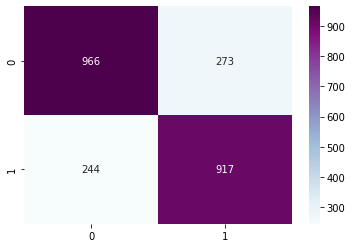

In [ ]:
# confusion matrix of Random Forest (Ngram)
cm = confusion_matrix(y_test_ngram,predicted_rfc_ngram)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')

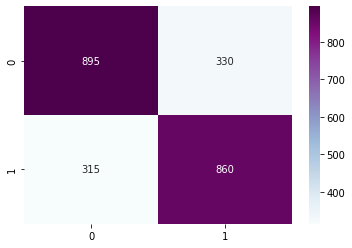

In [ ]:
# confusion matrix of Random Forest (Neural Based)
cm = confusion_matrix(y_test_nn,predicted_rfc_nn)
sns.heatmap(cm,cmap='BuPu',annot=True,fmt='d')